# Comparison between sklearn's and gensim's implementations of NMF

In [22]:
%load_ext line_profiler
from gensim.models.nmf import Nmf as GensimNmf
from gensim.parsing.preprocessing import preprocess_documents
from gensim import matutils
from sklearn.decomposition.nmf import NMF as SklearnNmf
import sklearn.decomposition.nmf
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from matplotlib import pyplot as plt

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


# 20newsgroups

In [23]:
from gensim.parsing.preprocessing import preprocess_documents

documents = preprocess_documents(fetch_20newsgroups().data[:1000])

In [24]:
from gensim.corpora import Dictionary

dictionary = Dictionary(documents)

dictionary.filter_extremes()

2018-06-03 15:46:51,379 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-06-03 15:46:51,576 : INFO : built Dictionary(17622 unique tokens: ['addit', 'bodi', 'bricklin', 'brought', 'bumper']...) from 1000 documents (total 136081 corpus positions)
2018-06-03 15:46:51,605 : INFO : discarding 14411 tokens: [('bricklin', 2), ('bumper', 4), ('edu', 661), ('funki', 4), ('lerxst', 2), ('line', 989), ('organ', 952), ('rac', 1), ('subject', 1000), ('tellm', 2)]...
2018-06-03 15:46:51,606 : INFO : keeping 3211 tokens which were in no less than 5 and no more than 500 (=50.0%) documents
2018-06-03 15:46:51,614 : INFO : resulting dictionary: Dictionary(3211 unique tokens: ['addit', 'bodi', 'brought', 'call', 'car']...)


In [25]:
corpus = [
    dictionary.doc2bow(document)
    for document
    in documents
]

bow_matrix = matutils.corpus2dense(corpus, len(dictionary), len(corpus))

## Sklearn NMF

In [26]:
%%time
# %%prun

sklearn_nmf = SklearnNmf(n_components=5, tol=1e-5, max_iter=int(1e9), random_state=42)

W = sklearn_nmf.fit_transform(bow_matrix)
H = sklearn_nmf.components_

CPU times: user 1.45 s, sys: 891 ms, total: 2.34 s
Wall time: 1.29 s


In [27]:
# %lprun -f sklearn.decomposition.nmf._fit_coordinate_descent sklearn_nmf.fit_transform(bow_matrix)

In [28]:
np.linalg.norm(bow_matrix - W.dot(H), 'fro')

482.0895496423899

## Gensim NMF

In [29]:
%%time
# %%prun

PASSES = 2

gensim_nmf = GensimNmf(
    corpus,
    chunksize=len(corpus),
    num_topics=5,
    id2word=dictionary,
    lambda_=1000,
    kappa=1.,
    passes=PASSES,
    normalize=False
)

2018-06-03 15:46:54,131 : INFO : Loss (no outliers): 625.9286431543794	Loss (with outliers): 625.9286431543794
2018-06-03 15:46:55,025 : INFO : Loss (no outliers): 520.2123565007096	Loss (with outliers): 520.2123565007096


CPU times: user 2.38 s, sys: 2.21 s, total: 4.59 s
Wall time: 1.78 s


In [31]:
# %lprun -f GensimNmf._solve_w GensimNmf(corpus, chunksize=len(corpus), num_topics=5, id2word=dictionary, lambda_=1., kappa=1.)

In [32]:
W = gensim_nmf.get_topics().T
H = np.hstack(gensim_nmf[bow] for bow in corpus)

In [33]:
np.linalg.norm(matutils.corpus2dense(corpus, len(dictionary), len(documents)) - W.dot(H), 'fro')

498.12465073357987

In [34]:
gensim_nmf.show_topics()

[(0,
  '0.077*"jesu" + 0.060*"peopl" + 0.042*"matthew" + 0.038*"said" + 0.030*"dai" + 0.028*"come" + 0.024*"christian" + 0.024*"know" + 0.024*"sai" + 0.022*"time"'),
 (1,
  '0.039*"argument" + 0.025*"jesu" + 0.023*"exampl" + 0.023*"conclus" + 0.022*"true" + 0.019*"premis" + 0.017*"gener" + 0.015*"question" + 0.015*"like" + 0.014*"occur"'),
 (2,
  '0.206*"max" + 0.005*"space" + 0.005*"nasa" + 0.004*"umd" + 0.004*"mission" + 0.004*"armenian" + 0.004*"orbit" + 0.003*"applic" + 0.003*"father" + 0.003*"shuttl"'),
 (3,
  '0.058*"health" + 0.056*"max" + 0.033*"us" + 0.026*"report" + 0.022*"public" + 0.022*"state" + 0.021*"diseas" + 0.020*"infect" + 0.019*"user" + 0.019*"ag"'),
 (4,
  '0.181*"armenian" + 0.093*"good" + 0.066*"turkish" + 0.064*"post" + 0.064*"russian" + 0.055*"genocid" + 0.051*"excel" + 0.047*"com" + 0.045*"articl" + 0.045*"turk"')]

In [43]:
DOC_IDX = 5

print(documents[DOC_IDX])

gensim_nmf.get_document_topics(corpus[DOC_IDX])

['dfo', 'vttoulu', 'tko', 'vtt', 'foxvog', 'dougla', 'subject', 'reword', 'second', 'amend', 'idea', 'organ', 'vtt', 'line', 'articl', 'cdt', 'stratu', 'com', 'tavar', 'write', 'articl', 'dfo', 'vttoulu', 'tko', 'vtt', 'foxvog', 'dougla', 'write', 'articl', 'cdt', 'stratu', 'com', 'tavar', 'write', 'articl', 'jrutledg', 'ulowel', 'edu', 'john', 'lawrenc', 'rutledg', 'write', 'massiv', 'destruct', 'power', 'modern', 'weapon', 'make', 'cost', 'accident', 'crimial', 'usag', 'weapon', 'great', 'weapon', 'mass', 'destruct', 'need', 'control', 'govern', 'individu', 'access', 'result', 'needless', 'death', 'million', 'make', 'right', 'peopl', 'bear', 'modern', 'weapon', 'non', 'exist', 'thank', 'state', 'come', 'needless', 'disagre', 'count', 'believ', 'individu', 'right', 'weapon', 'mass', 'destruct', 'hard', 'believ', 'support', 'neighbor', 'right', 'nuclear', 'weapon', 'biolog', 'weapon', 'nerv', 'ga', 'properti', 'agre', 'keep', 'weapon', 'mass', 'destruct', 'hand', 'individu', 'hope', 's

array([[17.4492155 ],
       [10.47633717],
       [ 0.        ],
       [ 5.74474046],
       [ 4.91181848]])

From the personal experience I can say that the higher number of passes and shuffle of the trainset significantly improves performance.

Then, of course, you should perform hyperparameter tuning.

# Image of stars
### (For the sake of visualization of performance on sparse trainset)

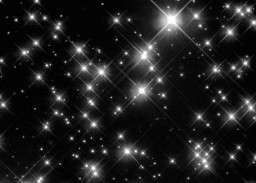

In [13]:
from PIL import Image
img = Image.open('stars_scaled.jpg').convert('L')
img

In [14]:
img_matrix = np.uint8(img.getdata()).reshape(img.size[::-1])
img_matrix.shape

(183, 256)

## Sklearn NMF

In [15]:
%%time

sklearn_nmf = SklearnNmf(n_components=10, tol=1e-5, max_iter=int(1e9))

W = sklearn_nmf.fit_transform(img_matrix)
H = sklearn_nmf.components_

CPU times: user 198 ms, sys: 241 ms, total: 439 ms
Wall time: 183 ms


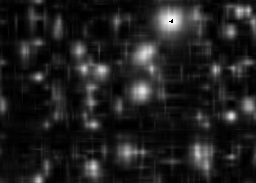

In [16]:
Image.fromarray(np.uint8(W.dot(H)), 'L')

## Gensim NMF

In [17]:
np.random.seed(42)

img_corpus = matutils.Dense2Corpus(img_matrix[np.random.choice(img_matrix.shape[0], img_matrix.shape[0], replace=False)].T)

In [18]:
%%time

import itertools

gensim_nmf = GensimNmf(
    img_corpus,
    chunksize=len(corpus),
    num_topics=10,
    passes=2,
    id2word={k: k for k in range(img_matrix.shape[1])},
    lambda_=1000,
    kappa=1,
    normalize=False
)

2018-06-02 20:40:19,571 : INFO : Loss (no outliers): 9092.939650164284	Loss (with outliers): 9092.939650164284
2018-06-02 20:40:19,766 : INFO : Loss (no outliers): 5796.750747142226	Loss (with outliers): 5796.750747142226


CPU times: user 401 ms, sys: 311 ms, total: 712 ms
Wall time: 312 ms


In [19]:
W = gensim_nmf.get_topics().T
H = np.hstack(gensim_nmf[bow] for bow in matutils.Dense2Corpus(img_matrix.T))

### Reconstructed matrix:

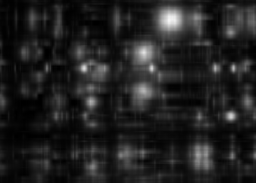

In [20]:
Image.fromarray(np.uint8(W.dot(H).T), 'L')